# Machine Learning 3253 - Project Assignment



## Team Members
    
* Craig Barbisan
* Nisha Choondassery
* Mark Hubbard
* Italy Segal



## Project Overview

Using the "Movies Dataset"  from Kaggle, this project will create an optimal model for predicting a movie's rating.

## Notebook Overview

This notebook will explore the data, evaluate some models and draw conclusions.

It is divided into the following main sections:

1. Setup - seting up the Notebook environment.
2. Data - acquiring, exploring and processing the data.
3. Model - training and testing various models.
4. Analysis - analyzing the model results.
5. Summary - summarizing the observations and conclusions.

# 1.0 Setup

## Kaggle Account

In [0]:
# Kaggle credentials (optional)
USERID   = 'none'
PASSWORD = 'none'

## Libraries

In [1]:
# import the basic libraries
import os
import numpy as np
import pandas as pd
import json
import ast
import tarfile

# make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)

# ensure full display for dataframe content
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('precision', 5)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.max_colwidth', -1)
pd.set_option('colheader_justify', 'left')

# enable basic plots with pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# enable advanced plots
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.2)

In [2]:
# import sklearn libraries

# pipeline processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# data splitting
from sklearn.model_selection import train_test_split

# classifier models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
# suppress warnings
import warnings
# warnings.filterwarnings('ignore')

## Common Functions

### Exploratory Data Analysis Functions

In [4]:
# function: basic schema analysis
def quick_schema_analysis(df):
    print("Basic Schema Analysis for dataframe=" + df.name)
    print("************************************************")
    
    print("Rows and Columns:")
    print(df.shape)
    print(df.info())
    print("\n")
    
    print("Null Values - percentage:")
    print((1 - df.count()/len(df.index)) * 100)
    print("\n")
    
    print("Null Values - count:")
    print(df.isnull().sum())
    print("\n")

In [5]:
# function: basic data analysus
def quick_data_analysis(df):
    print("Basic Data Analysis for dataframe=" + df.name)
    print(df.shape)

### Exploratory Data Analysis Plots

In [6]:
# function: plot a column vs column correlation map
def plot_data_correlation(data):
    sns.pairplot(data)

In [7]:
# function: plot a complete histogram for all columns
def plot_data_histograms(data):
    plt.figure()
    data.hist(bins=50, figsize=(20,15))
    plt.show()

In [8]:
# function: plot percentage/count of categoric feature values per target value
def plot_feature_vs_target(data, column_id, feature_name, target_name):

    plt.figure()
    plt.title(target_name + " by " + feature_name + " (Percent)")
    plt.xlabel(feature_name)
    ax = sns.barplot(x=column_id, y=column_id, data=data, estimator=lambda x: len(x) / len(data) * 100)
    ax.set(ylabel="Percent")
    plt.show()

    plt.figure()
    plt.title(target_name + " by " + feature_name + " (Count)")
    sns.countplot(x=column_id, hue=target_name, data=data, palette='RdBu')
    plt.show()

In [9]:
# function: plot a correlation heatmap
def plot_correlation(data):
    X = data.iloc[:,0:20]  #independent columns
    y = data.iloc[:,-1]    #target column i.e price range

    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))

    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Model Evaluation Plots

#### Confusion Matrix Plots

In [10]:
# function: generate a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

def generate_confusion_matrix(classifier, X, y, cv):
  
    # calculate the predicted values
    y_cvp = cross_val_predict(classifier, X, y, cv=cv)
    
    # calculate the confusion matrix
    cm = confusion_matrix(y, y_cvp)

    tn, fp, fn, tp = confusion_matrix(y, y_cvp).ravel()
    print("True  Negatives: {}".format(tn))
    print("False Positives: {}".format(fp))
    print("False Negatives: {}".format(fn))
    print("True  Positives: {}".format(tp))

    # plot the confusion matrix
    plot_confusion_matrix(cm, classes=[target_name_negative, 
                                       target_name_positive], 
                          normalize=False, title='Confusion Matrix')

In [11]:
# function: plot a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7, 7))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix (with normalization)')
    else:
        print('Confusion Matrix (without normalization)')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#### Precision Recall Plots

In [12]:
# function: generate the Precision-Recall curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

def generate_precision_vs_recall(y, y_scores):

    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

    plot_precision_vs_recall(precisions, recalls)
  
    print(precision_score(y_train, clf_y_train_cvp))
    print(recall_score(y_train, clf_y_train_cvp))

In [13]:
# function: plot the precision-recall-threshold curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.show()

In [14]:
# function: plot the precision vs recall curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()
    
    print("True  Negatives: {}".format(tn))
    print("False Positives: {}".format(fp))
    print("False Negatives: {}".format(fn))
    print("True  Positives: {}".format(tp))

#### ROC Plots

In [15]:
# function: generate ROC curve
def generate_roc_curve(classifier, X, y, cv):
  
    # calculate probabilities
    y_probability_score = calculate_probability_score(classifier, X, y, cv)
    
    fpr, tpr, thresholds = roc_curve(y, y_probability_score)
    
    # plot the ROC curve
    plt.title('ROC Curve')

    plot_roc_curve(fpr, tpr,'Best Classifier')

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc='lower right', fontsize=16)
    plt.show()
    
    print("AUC Score: {}".format(roc_auc_score(y, y_probability_score)))

In [16]:
# function: plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])   

In [17]:
# calculate probability score
from sklearn.model_selection import cross_val_predict

def calculate_probability_score(classifier, X, y, cv):

  clf_y_probas = cross_val_predict(classifier, X, y, cv=cv, 
                                         method="predict_proba")

  clf_y_scores = clf_y_probas[:, 1] # score = proba of positive class
  
  return clf_y_scores

### Data Functions

In [18]:
# class: DataFrameSelector transform (scikit doesn't support DataFrames yet)
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self.fit(X, y)
    def transform(self, X):
        return X[self.attribute_names].copy()
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [19]:
# function: download a file from Kaggle in chunks
import requests

def download_from_Kaggle(remote_file, local_file):

    kaggle_info = {'UserName': USERNAME, 'Password': PASSWORD}

    r = requests.get(remote_file, auth=(USERNAME, PASSWORD))

    # r = requests.post(r.url, data = kaggle_info)
    
    print('here...')
    # read and write 512KB chunks at a time
    f = open(local_file, 'wb')
    for chunk in r.iter_content(chunk_size = 512 * 1024):
        if chunk:
            f.write(chunk)
            print('chunk')

    f.close()

In [20]:
# function: download an entire file from a public Web site
from urllib.request import urlretrieve

def download_from_Web(remote_file, local_file):
    urlretrieve(remote_file, local_file)

In [21]:
# function: download files from the internet and optionally unzip them
from zipfile import ZipFile

def fetch_data(url, file, local_path, zip=False):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    
    remote_file = url
    local_file  = os.path.join(local_path, file)
   
    print(remote_file)
    
    if not os.path.isfile(local_file):
        print('Downloading ' + file + '...')
        
        download_from_Web(remote_file, local_file)

        print('Download complete.')
        
    else:
        print('Already downloaded.')

    if zip:
       unzip_file(local_file)


In [22]:
# function: unzip a file

def unzip_file(file):
 
    zip_path = file[:-4]
  
    if (os.path.isdir(zip_path)):
        print('Already extracted.')
    else:
        print('Extracting...')
        zfile = ZipFile(file, 'r')
        print(zfile.infolist())
        zfile.extractall(zip_path)
        zfile.close()
        print('Extraction complete.')

In [69]:
# convert json to abstract syntax trees (ast)

# use ast because json data has single quotes in the csvs
# which is invalid for a json object (should be double quotes)

def convert_json_to_ast(df, json_columns):
  
    for column in json_columns:
        df[column] = df[column].apply(lambda x: np.nan if pd.isnull(x)
                                                else ast.literal_eval(str(x)))

In [92]:
# convert the columns that contain the dictionary field with the name value in its ast 
def get_dict_val_from_ast(df,columns,field_name, fillna_str):
    for column in columns:
        df[column] = df[column].fillna(fillna_str) # first replace NaN with fillna_str
        df[column] = df[column].apply(lambda x: x[field_name] if isinstance(x, dict) else [])  #.apply(ast.literal_eval)

In [164]:
# convert the columns that contain the list field with the name value in its ast
def get_list_val_from_ast(df,columns,field_name, fillna_str=None, new_col_dict=None):
    for column in columns:
        if(fillna_str):
            df[column] = df[column].fillna(fillna_str) # first replace NaN with fillna_str
        new_column = column
        if(new_col_dict and column in new_col_dict):
            new_column = new_col_dict[column]
        df[new_column] = df[column].apply(lambda x: [i[field_name] for i in x] if isinstance(x, list) else [])  #.apply(ast.literal_eval)

In [121]:
# convert to float
def cast_to_float(df, columns,d_cast=None):
    for column in columns:
        if(d_cast):
            df[column] = pd.to_numeric(df[column],errors='coerce',downcast=d_cast)
        else:
            df[column] = pd.to_numeric(df[column],errors='coerce')
                

In [107]:
# fill in empty values with mean
def replace_empty_with_mean(df, columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].mean())

In [24]:
# review column results after data cleansing

def assess_column(df, column, categories=False):
    print(df[column].head(10))
    print('Number of null entries: ', df[column].isnull().sum())
    if categories:
      print(df[column].unique())

In [327]:
from urllib.parse import urlparse

# get domain from url
def get_url_domain(url):
    if(not pd.isnull(url)):
        parsed_uri = urlparse(url )
        return '{uri.netloc}'.format(uri=parsed_uri)
    else:
        return url

In [0]:
# list all unique values in a categorical column

# 2.0 Data 

## Data Acquisition

The dataset for this project is sourced from https://www.kaggle.com/rounakbanik/the-movies-dataset.

Credit: Rounak Banik

This dataset is an ensemble of data collected from TMDB and GroupLens.
* The Movie Details (i.e. Metadata), Credits and Keywords have been collected from the TMDB Open API.
* The Movie Links and Ratings have been obtained from the Official GroupLens website.

The following spreadsheets are used by this project:

* __movies_metadata.csv__: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

* __credits.csv__: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

* __keywords.csv__:  Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

* __links.csv__: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

* __ratings_small.csv__: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset can be accessed at https://grouplens.org/datasets/movielens/latest/

The dataset for this project is stored as a public file on Dropbox:
https://www.dropbox.com/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1

(Kaggle requires multiple manual steps by the notebook user and Google Drive injects a virus detection warning  page for downloads of large files).

In [25]:
# specify file names and locations
URL_DOMAIN    = 'https://www.dropbox.com'
URL_PATH      = '/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1'

G_URL_DOMAIN  = 'https://drive.google.com'
G_URL_PATH    = '/uc?export=download&confirm=no_antivirus&id=16zqahjyBrcdJYKBMK-zo2NbRHyyNHVQJ'

K_URL_DOMAIN2 = 'http://www.kaggle.com'
K_URL_PATH    = '/rounakbanik/the-movies-dataset/downloads/'

PROJECT_LOCAL_DIR  = '/content/movies/'
PROJECT_OUTPUT_DIR = '/content/movies/output'
PROJECT_FILE       = 'the-movies-dataset.zip'

In [26]:
# download the dataset file

url = URL_DOMAIN + URL_PATH

fetch_data(url, PROJECT_FILE, PROJECT_LOCAL_DIR, zip=True)

https://www.dropbox.com/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1
Download complete.
Extracting...
[<ZipInfo filename='ratings.csv' compress_type=deflate file_size=709550327 compress_size=178245813>, <ZipInfo filename='ratings_small.csv' compress_type=deflate file_size=2438266 compress_size=674830>, <ZipInfo filename='links.csv' compress_type=deflate file_size=989107 compress_size=427810>, <ZipInfo filename='links_small.csv' compress_type=deflate file_size=183372 compress_size=80922>, <ZipInfo filename='keywords.csv' compress_type=deflate file_size=6231943 compress_size=1455770>, <ZipInfo filename='movies_metadata.csv' compress_type=deflate file_size=34445126 compress_size=12795897>, <ZipInfo filename='credits.csv' compress_type=deflate file_size=189917659 compress_size=45180229>]
Extraction complete.


Create dataframes for each of the spreadsheets.

As part of loading the dataframes, convert null values to NaN on the fly (via pd.read_csv).

By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, ‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, ‘n/a’, ‘nan’, ‘null’.

In [70]:
# initialize the dataframes (and convert null fields on the fly)

zip_path = os.path.join(PROJECT_LOCAL_DIR, PROJECT_FILE[:-4])


metadata_file = os.path.join(zip_path, 'movies_metadata.csv')
credits_file  = os.path.join(zip_path, 'credits.csv')
plot_file     = os.path.join(zip_path, 'keywords.csv')
links_file    = os.path.join(zip_path, 'links.csv')
ratings_file  = os.path.join(zip_path, 'ratings_small.csv')

# load the metadata dataframe

metadata = pd.read_csv(metadata_file,
                     dtype = 'unicode',
                     na_values = ['no info', '.']
                    )

# load the credits dataframe

credits = pd.read_csv(credits_file,
                      dtype = 'unicode',
                      na_values = ['no info', '.']
                     )

# load the plot dataframe

plot =  pd.read_csv(plot_file,
                    dtype = 'unicode',
                    na_values = ['no info', '.']
                   )

# load the links dataframe

links =  pd.read_csv(links_file,
                    dtype = 'unicode',
                    na_values = ['no info', '.']
                   )

# load the ratings dataframe

ratings = pd.read_csv(ratings_file,
                      dtype = 'unicode',
                      na_values = ['no info', '.']
                     )

dataframes = [metadata, credits, plot, links, ratings]

## Exploratory Data Analysis (EDA)

In [71]:
# make copies of data for EDA

metadata_copy = metadata.copy()
metadata_copy.name = 'metadata'

credits_copy = credits.copy()
credits_copy.name = 'credit'

plot_copy = plot.copy()
plot_copy.name = 'plot'

links_copy = links.copy()
links_copy.name = 'links'

ratings_copy = ratings.copy()
ratings_copy.name = 'ratings'

eda_dataframes = [metadata_copy,
                  credits_copy,
                  plot_copy,
                  links_copy,
                  ratings_copy
                 ]


### Explore the "metadata" data

__Features__

* __adult__: Indicates if the movie is X-Rated or Adult.
* __belongs_to_collection__: A stringified dictionary that gives information on the movie series the particular film belongs to.
* __budget__: The budget of the movie in dollars.
* __genres__: A stringified list of dictionaries that list out all the genres associated with the movie.
* __homepage__: The Official Homepage of the move.
* __id__: The ID of the movie.
* __imdb_id__: The IMDB ID of the movie.
* __original_language__: The language in which the movie was originally shot in.
* __original_title__: The original title of the movie.
* __overview__: A brief blurb of the movie.
* __popularity__: The Popularity Score assigned by TMDB.
* __poster_path__: The URL of the poster image.
* __production_companies__: A stringified list of production companies involved with the making of the movie.
* __production_countries__: A stringified list of countries where the movie was shot/produced in.
* __release_date__: Theatrical Release Date of the movie.
* __revenue__: The total revenue of the movie in dollars.
* __runtime__: The runtime of the movie in minutes.
* __spoken_languages__: A stringified list of spoken languages in the film.
* __status__: The status of the movie (Released, To Be Released, Announced, etc.)
* __tagline__: The tagline of the movie.
* __title__: The Official Title of the movie.
* __video__: Indicates if there is a video present of the movie with TMDB.
* __vote_average__: The average rating of the movie.
* __vote_count__: The number of votes by users, as counted by TMDB.

In [72]:
# quick review of the metadata data
quick_schema_analysis(metadata_copy)
quick_data_analysis(metadata_copy)

metadata_copy.head(5)

Basic Schema Analysis for dataframe=metadata
************************************************
Rows and Columns:
(45466, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null object
runtime          

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg', 'backdrop_path

In [73]:
# check if there are any duplicates

print(metadata_copy.shape)
print(metadata_copy.drop_duplicates().shape)

(45466, 24)
(45449, 24)


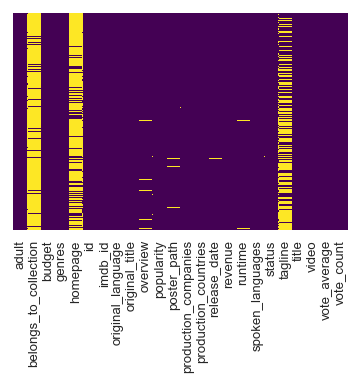

In [31]:
# plot a heatmap of nulls
sns.heatmap(metadata_copy.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

### Explore the "credits" data

In [74]:
# quick review of the credits data

quick_schema_analysis(credits_copy)
quick_data_analysis(credits_copy)

credits_copy.head(3)

Basic Schema Analysis for dataframe=credit
************************************************
Rows and Columns:
(45476, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null object
dtypes: object(3)
memory usage: 1.0+ MB
None


Null Values - percentage:
cast    0.0
crew    0.0
id      0.0
dtype: float64


Null Values - count:
cast    0
crew    0
id      0
dtype: int64


Basic Data Analysis for dataframe=credit
(45476, 3)


cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Explore the "plot" data

In [75]:
# quick review of the plot data

quick_schema_analysis(plot_copy)
quick_data_analysis(plot_copy)

plot_copy.head(5)

Basic Schema Analysis for dataframe=plot
************************************************
Rows and Columns:
(46419, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null object
keywords    46419 non-null object
dtypes: object(2)
memory usage: 725.4+ KB
None


Null Values - percentage:
id          0.0
keywords    0.0
dtype: float64


Null Values - count:
id          0
keywords    0
dtype: int64


Basic Data Analysis for dataframe=plot
(46419, 2)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'name': ""based on children's book""}, {'id': 33467, 'name': 'new home'}, {'id': 158086, 'name': 'recluse'}, {'id': 158091, 'name': 'giant insect'}]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': 'duringcreditsstinger'}, {'id': 208510, 'name': 'old men'}]"
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id': 14768, 'name': 'single mother'}, {'id': 15160, 'name': 'divorce'}, {'id': 33455, 'name': 'chick flick'}]"
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'confidence'}, {'id': 4995, 'name': 'aging'}, {'id': 5600, 'name': 'daughter'}, {'id': 10707, 'name': 'mother daughter relationship'}, {'id': 13149, 'name': 'pregnancy'}, {'id': 33358, 'name': 'contraception'}, {'id': 170521, 'name': 'gynecologist'}]"


### Explore the links data

In [76]:
# quick review of the links data

quick_schema_analysis(links_copy)
quick_data_analysis(links_copy)

links_copy.head(5)

Basic Schema Analysis for dataframe=links
************************************************
Rows and Columns:
(45843, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
movieId    45843 non-null object
imdbId     45843 non-null object
tmdbId     45624 non-null object
dtypes: object(3)
memory usage: 1.0+ MB
None


Null Values - percentage:
movieId    0.00000
imdbId     0.00000
tmdbId     0.47772
dtype: float64


Null Values - count:
movieId    0  
imdbId     0  
tmdbId     219
dtype: int64


Basic Data Analysis for dataframe=links
(45843, 3)


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


### Explore the "ratings" data

In [77]:
# quick review of the ratings data

quick_schema_analysis(ratings_copy)
quick_data_analysis(ratings_copy)

ratings_copy.head(5)

Basic Schema Analysis for dataframe=ratings
************************************************
Rows and Columns:
(100004, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null object
movieId      100004 non-null object
rating       100004 non-null object
timestamp    100004 non-null object
dtypes: object(4)
memory usage: 3.1+ MB
None


Null Values - percentage:
userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64


Null Values - count:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Basic Data Analysis for dataframe=ratings
(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [78]:
# check if there are any duplicates

print(ratings_copy.shape)
print(ratings_copy.drop_duplicates().shape)

(100004, 4)
(100004, 4)


## Data Cleansing

### Clean the metadata data

In [79]:
metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415


In [80]:
metadata['id'].isnull().sum()

0

Perform the following type conversions:
* Convert __release_date__ to datetime
* Convert __budget__ and __revenue__ to numerics (use 0 for NaN values)
* Convert all JSON fields to abstract syntax trees
* Convert __vote_average__ to float
* Convert __vote_count__ to integer

In [81]:
# convert each item of release_date to a datetime type entity

metadata['release_date'] = pd.to_datetime(metadata['release_date'],
                                          errors='coerce')

# metadata['release_date'] = metadata['release_date'].fillna('?')

In [40]:
assess_column(metadata, 'release_date')

0   1995-10-30
1   1995-12-15
2   1995-12-22
3   1995-12-22
4   1995-02-10
5   1995-12-15
6   1995-12-15
7   1995-12-22
8   1995-12-22
9   1995-11-16
Name: release_date, dtype: datetime64[ns]
Number of null entries:  90


In [82]:
# convert budget and revenue fields to be numeric
# (...and convert 0 to a NaN to enable budget and revenue math)

metadata['budget']  = pd.to_numeric(metadata['budget'],  errors='coerce')
metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')

metadata['budget']  = metadata['budget'].replace(0, np.nan)
metadata['revenue'] = metadata['revenue'].replace(0, np.nan)

In [42]:
assess_column(metadata, 'budget')
assess_column(metadata, 'revenue')

0    30000000.0
1    65000000.0
2   NaN        
3    16000000.0
4   NaN        
5    60000000.0
6    58000000.0
7   NaN        
8    35000000.0
9    58000000.0
Name: budget, dtype: float64
Number of null entries:  36576
0    3.73554e+08
1    2.62797e+08
2   NaN         
3    8.14522e+07
4    7.65789e+07
5    1.87437e+08
6   NaN         
7   NaN         
8    6.43502e+07
9    3.52194e+08
Name: revenue, dtype: float64
Number of null entries:  38058


In [83]:
# convert json columns to abstract syntax trees

json_columns = ['belongs_to_collection',
                'genres',
                'production_companies',
                'production_countries',
                'spoken_languages'
               ]

convert_json_to_ast(metadata, json_columns)

In [90]:
# def get_val_from_ast(df,columns,field_name)
get_dict_val_from_ast(metadata, ['belongs_to_collection'],'name','')

In [0]:
# replaced by the previous cell
# convert the belongs_to_collection field with the name value in its ast
# (...but first replace NaN with '')

metadata['belongs_to_collection'] = (metadata['belongs_to_collection']
                                     .fillna('')
                                     .apply(lambda x: x['name']
                                            if isinstance(x, dict)
                                            else [])
#                                    .apply(ast.literal_eval)    
                                    )

In [91]:
assess_column(metadata, 'belongs_to_collection')

0    Toy Story Collection          
1    []                            
2    Grumpy Old Men Collection     
3    []                            
4    Father of the Bride Collection
5    []                            
6    []                            
7    []                            
8    []                            
9    James Bond Collection         
Name: belongs_to_collection, dtype: object
Number of null entries:  0


In [96]:
get_list_val_from_ast(metadata, ['genres'],'name','Other')

In [0]:
# replaced by the previous cell
# convert the genre field to use the genre name value in its ast
# (...but first replace NaN with 'Other')

metadata['genres'] = (metadata['genres']
                      .fillna('Other') 
                      .apply(lambda x: [i['name'] for i in x] 
                                       if isinstance(x, list)
                                       else [])
#                      .apply(ast.literal_eval)
                     )

In [97]:
assess_column(metadata, 'genres')

0    [Animation, Comedy, Family]       
1    [Adventure, Fantasy, Family]      
2    [Romance, Comedy]                 
3    [Comedy, Drama, Romance]          
4    [Comedy]                          
5    [Action, Crime, Drama, Thriller]  
6    [Comedy, Romance]                 
7    [Action, Adventure, Drama, Family]
8    [Action, Adventure, Thriller]     
9    [Adventure, Action, Thriller]     
Name: genres, dtype: object
Number of null entries:  0


In [98]:
get_list_val_from_ast(metadata, ['production_companies'],'name','')

In [0]:
# replaced by the previous cell
# convert the production_company to its name value from its ast
# (...but first replace NaN with 'Unknown')

metadata['production_companies'] = (metadata['production_companies']
                                    .fillna('')
                                    .apply(lambda x: [i['name'] for i in x]
                                                     if isinstance(x, list)
                                                     else [])
#                                    .apply(ast.literal_eval)
                                   )

In [99]:
assess_column(metadata, 'production_companies')

0    [Pixar Animation Studios]                                                                                                                                      
1    [TriStar Pictures, Teitler Film, Interscope Communications]                                                                                                    
2    [Warner Bros., Lancaster Gate]                                                                                                                                 
3    [Twentieth Century Fox Film Corporation]                                                                                                                       
4    [Sandollar Productions, Touchstone Pictures]                                                                                                                   
5    [Regency Enterprises, Forward Pass, Warner Bros.]                                                                                                              
6    [Para

In [100]:
get_list_val_from_ast(metadata, ['production_countries'],'iso_3166_1','Other')

In [0]:
# replaced by the previous cell
# convert the production_countries to their ISO 3166.1 values from the ast
# (...but first replace NaN with 'Other')

metadata['production_countries'] = (metadata['production_countries'] 
                                    .fillna('Other')
                                    .apply(lambda x: [i['iso_3166_1'] for i in x]
                                                      if isinstance(x, list)
                                                      else [])
#                                    .apply(ast.literal_eval)
                                   )

In [101]:
assess_column(metadata, 'production_countries')

0    [US]    
1    [US]    
2    [US]    
3    [US]    
4    [US]    
5    [US]    
6    [DE, US]
7    [US]    
8    [US]    
9    [GB, US]
Name: production_countries, dtype: object
Number of null entries:  0


In [103]:
cast_to_float(metadata, ['runtime'])

In [0]:
# replaced by the previous cell
# convert runtime to float

metadata['runtime'] = pd.to_numeric(metadata['runtime'],
                                       errors='coerce'
                                      )

In [104]:
assess_column(metadata, 'runtime')

0    81.0 
1    104.0
2    101.0
3    127.0
4    106.0
5    170.0
6    127.0
7    97.0 
8    106.0
9    130.0
Name: runtime, dtype: float64
Number of null entries:  263


In [105]:
get_list_val_from_ast(metadata, ['spoken_languages'],'name','Other')

In [0]:
# replaced by the previous cell
# convert the spoken languages to values from the ast
# (...but first replace NaN with 'Other')

metadata['spoken_languages'] = (metadata['spoken_languages']
                                .fillna('Other') 
                                .apply(lambda x: [i['name'] for i in x] 
                                      if isinstance(x, list) 
                                      else [])
#                               .apply(ast.literal_eval)
                               )

In [106]:
assess_column(metadata, 'spoken_languages')

0    [English]                  
1    [English, Français]        
2    [English]                  
3    [English]                  
4    [English]                  
5    [English, Español]         
6    [Français, English]        
7    [English, Deutsch]         
8    [English]                  
9    [English, Pусский, Español]
Name: spoken_languages, dtype: object
Number of null entries:  0


In [108]:
cast_to_float(metadata, ['vote_average'])

replace_empty_with_mean(metadata, ['vote_average'])

In [0]:
# replaced by the previous cell
# convert vote_average to float

metadata['vote_average'] = pd.to_numeric(metadata['vote_average'],
                                         errors='coerce')
                              

metadata['vote_average'] = (metadata['vote_average']
                            .fillna(metadata['vote_average'].mean())
                           )

In [110]:
assess_column(metadata, 'vote_average')

0    7.7
1    6.9
2    6.5
3    6.1
4    5.7
5    7.7
6    6.2
7    5.4
8    5.5
9    6.6
Name: vote_average, dtype: float64
Number of null entries:  0


In [122]:
cast_to_float(metadata, ['vote_count'],'integer')

In [123]:
metadata['vote_count'] = metadata['vote_count'].fillna(0)

In [0]:
# replaced by the 2 previous cells
# convert vote_count to integer

metadata['vote_count'] = pd.to_numeric(metadata['vote_count'],
                                       errors='coerce',
                                       downcast='integer'
                                      )

metadata['vote_count'] = (metadata['vote_count'].fillna(0))

In [124]:
assess_column(metadata, 'vote_count')

0    5415.0
1    2413.0
2    92.0  
3    34.0  
4    173.0 
5    1886.0
6    141.0 
7    45.0  
8    174.0 
9    1194.0
Name: vote_count, dtype: float64
Number of null entries:  0


### Clean the credits data

In [125]:
credits.head(1)

cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gender': 1, 'id': 8873, 'name': 'Annie Potts

In [126]:
# convert json columns to abstract syntax trees

json_columns = ['cast', 'crew']
    
convert_json_to_ast(credits, json_columns)

In [127]:
# populate cast and crew with string extractions from their current ast

credits['cast'] = (credits['cast'].fillna('')
#                                   .apply(ast.literal_eval)
                  )
 
credits['crew'] = (credits['crew'].fillna('')
#                                 .apply(ast.literal_eval)
                  )

In [128]:
assess_column(credits, 'cast')
assess_column(credits, 'crew')

0    [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2

### Clean the plot data

In [129]:
plot.head(1)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"


In [130]:
# convert json columns to abstract syntax trees

json_columns = ['keywords']

convert_json_to_ast(plot, json_columns)

In [131]:
get_list_val_from_ast(plot, ['keywords'],'name','')

In [0]:
# replace by previous cell
# convert the keywords field to use the string values in its ast
# (...but first replace NaN with 'Unknown')

plot['keywords'] = (plot['keywords']
                    .fillna('') 
                    .apply(lambda x: [i['name'] for i in x] 
                                     if isinstance(x, list)
                                     else [])
#                   .apply(ast.literal_eval)
                     )

In [132]:
assess_column(plot, 'keywords')

0    [jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]                                                                                                                                                           
1    [board game, disappearance, based on children's book, new home, recluse, giant insect]                                                                                                                                                                  
2    [fishing, best friend, duringcreditsstinger, old men]                                                                                                                                                                                                   
3    [based on novel, interracial relationship, single mother, divorce, chick flick]                                                                                                                                                          

#### Clean the ratings data

In [258]:
ratings = pd.read_csv(ratings_file,
                      dtype = 'unicode',
                      na_values = ['no info', '.']
                     )

In [259]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [260]:
assess_column(ratings, 'rating')

0    2.5
1    3.0
2    3.0
3    2.0
4    4.0
5    2.0
6    2.0
7    2.0
8    3.5
9    2.0
Name: rating, dtype: object
Number of null entries:  0


In [0]:
# convert timestamp to a datetime entity

# ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], errors='coerce')

In [261]:
assess_column(ratings, 'timestamp')

0    1260759144
1    1260759179
2    1260759182
3    1260759185
4    1260759205
5    1260759151
6    1260759187
7    1260759148
8    1260759125
9    1260759131
Name: timestamp, dtype: object
Number of null entries:  0


## Data Merge

In [262]:
# compare the shapes of all the dataframes

print(metadata.shape)
print(credits.shape)
print(plot.shape)
print(links.shape)
print(ratings.shape)


(45466, 24)
(45476, 3)
(46419, 2)
(45843, 3)
(100004, 4)


In [192]:
# initialize the merged dataframe "movies"
movies = metadata.copy()
print(movies.shape)

(45466, 24)


### Merge metadata and credit 

In [193]:
# perform a left join of credits to movies (adds 4 columns)
movies = movies.merge(credits, on=["id"])
print(movies.shape)

(45538, 26)


In [198]:
movies.drop(['crew','cast'],axis=1).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,7.65789e+07,106.0,[English],Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0


In [167]:
movies.head(1)

adult  belongs_to_collection  budget     genres                        \
0  False  Toy Story Collection  30000000.0  [Animation, Comedy, Family]   

  homepage                              id   imdb_id    original_language  \
0  http://toystory.disney.com/toy-story  862  tt0114709  en                 

  original_title  \
0  Toy Story       

  overview                                                                                                                                                                                                                                                                                                          \
0  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.   

  popularity poster_path                       production_companies        \
0  21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg  [Pixar Animation Studios]   

  production_countries release_date  revenue      runtime spoken_languages  \
0  [US]                1995-10-30    3.73554e+08  81.0     [English]         

  status    tagline title      video   vote_average  vote_count  \
0  Released  NaN     Toy Story  False  7.7           5415.0       

  cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [200]:
movies.drop(['crew','cast'],axis=1).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]"
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[board game, disappearance, based on children's book, new home, recluse, giant insect]"
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0,"[fishing, best friend, duringcreditsstinger, old men]"
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0,"[based on novel, interracial relationship, single mother, divorce, chick flick]"
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,7.65789e+07,106.0,[English],Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0,"[baby, midlife crisis, confidence, aging, daughter, mother daughter relationship, pregnancy, contraception, gynecologist]"


### Merge plot

In [201]:
movies = movies.merge(plot, on=['id'])
print(movies.shape)

(48834, 28)


In [169]:
movies.head(1)

adult  belongs_to_collection  budget     genres                        \
0  False  Toy Story Collection  30000000.0  [Animation, Comedy, Family]   

  homepage                              id   imdb_id    original_language  \
0  http://toystory.disney.com/toy-story  862  tt0114709  en                 

  original_title  \
0  Toy Story       

  overview                                                                                                                                                                                                                                                                                                          \
0  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.   

  popularity poster_path                       production_companies        \
0  21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg  [Pixar Animation Studios]   

  production_countries release_date  revenue      runtime spoken_languages  \
0  [US]                1995-10-30    3.73554e+08  81.0     [English]         

  status    tagline title      video   vote_average  vote_count  \
0  Released  NaN     Toy Story  False  7.7           5415.0       

  cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [202]:
movies.drop(['crew','cast'],axis=1).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords_x,keywords_y
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]","[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]"
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[board game, disappearance, based on children's book, new home, recluse, giant insect]","[board game, disappearance, based on children's book, new home, recluse, giant insect]"
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0,"[fishing, best friend, duringcreditsstinger, old men]","[fishing, best friend, duringcreditsstinger, old men]"
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0,"[based on novel, interracial relationship, single mother, divorce, chick flick]","[based on novel, interracial relationship, single mother, divorce, chick flick]"
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures

In [206]:
print(movies.shape)

(48834, 28)


### Merge ratings

In [263]:
ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null object
movieId      100004 non-null object
rating       100004 non-null object
timestamp    100004 non-null object
dtypes: object(4)
memory usage: 3.1+ MB


In [264]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [265]:
print(ratings.shape)

(100004, 4)


In [266]:
# check movie 4
ratings.loc[ratings['movieId'] == '4']

,userId,movieId,rating,timestamp
3108,19,4,3.0,855192868
17340,113,4,3.0,844884590
19016,128,4,3.0,1049682515
23747,168,4,3.0,848879299
24960,182,4,3.0,845745077
32988,239,4,3.0,991862027
54673,391,4,2.0,891534197
63795,460,4,3.5,1072837815
64079,461,4,1.5,1090908852
74054,518,4,1.0,945365209


In [268]:
# convert the rating column to numeric
cast_to_float(ratings, ['rating'],'integer')

In [269]:
# create a new grouped ratings set
# ratings_new = ratings.groupby('movieId', as_index=False)[['rating']].mean()
ratings_new = ratings.groupby('movieId', as_index=False).agg({"rating" : "mean"})

In [270]:
# information on the new ratings data set
ratings_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9066 entries, 0 to 9065
Data columns (total 2 columns):
movieId    9066 non-null object
rating     9066 non-null float64
dtypes: float64(1), object(1)
memory usage: 212.5+ KB


In [271]:
# verify aggregation - check movie 4
ratings_new.loc[ratings_new['movieId'] == '4']

,movieId,rating
4147,4,2.38462


In [272]:
# inspect the new ratings data set
ratings_new.head()

,movieId,rating
0,1,3.87247
1,10,3.45082
2,100,3.42857
3,100017,3.00000
4,100032,2.00000


In [273]:
# check the shape before merging
print(movies.shape)

(48834, 28)


In [274]:
# TODO - how should ratings be joined?

movies = movies.merge(ratings_new, left_on=['id'], right_on=["movieId"], how="inner")
print(movies.shape)

(2876, 30)


### Review movies Dataframe

In [275]:
# explore new movies dataframe

movies.name = 'movies'

quick_schema_analysis(movies)
quick_data_analysis(movies)

movies.head(5)

Basic Schema Analysis for dataframe=movies
************************************************
Rows and Columns:
(2876, 30)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 30 columns):
adult                    2876 non-null object
belongs_to_collection    2876 non-null object
budget                   1277 non-null float64
genres                   2876 non-null object
homepage                 579 non-null object
id                       2876 non-null object
imdb_id                  2876 non-null object
original_language        2876 non-null object
original_title           2876 non-null object
overview                 2852 non-null object
popularity               2876 non-null object
poster_path              2872 non-null object
production_companies     2876 non-null object
production_countries     2876 non-null object
release_date             2875 non-null datetime64[ns]
revenue                  1220 non-null float64
runtime                  28

adult  belongs_to_collection   budget     genres                             \
0  False  []                     60000000.0  [Action, Crime, Drama, Thriller]   
1  False  James Bond Collection  58000000.0  [Adventure, Action, Thriller]      
2  False  []                     98000000.0  [Action, Adventure]                
3  False  []                     52000000.0  [Drama, Crime]                     
4  False  []                     16500000.0  [Drama, Romance]                   

  homepage                                      id    imdb_id     \
0  NaN                                           949   tt0113277   
1  http://www.mgm.com/view/movie/757/Goldeneye/  710   tt0113189   
2  NaN                                           1408  tt0112760   
3  NaN                                           524   tt0112641   
4  NaN                                           4584  tt0114388   

  original_language original_title          \
0  en                Heat                    
1  en                GoldenEye               
2  en                Cutthroat Island        
3  en                Casino                  
4  en                Sense and Sensibility   

  overview                                                                                                                                                                                                                                                                                                                                                                                          \
0  Obsessive master thief, Neil McCauley leads a top-notch crew on various insane heists throughout Los Angeles while a mentally unstable detective, Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence.                                                   
1  James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.                                                                                                                                                                                                                   
2  Morgan Adams and her slave, William Shaw, are on a quest to recover the three portions of a treasure map. Unfortunately, the final portion is held by her murderous uncle, Dawg. Her crew is skeptical of her leadership abilities, so she must complete her quest before they mutiny against her. This is made yet more difficult by the efforts of the British crown to end her pirate raids.   
3  The life of the gambling paradise – Las Vegas – and its dark mafia underbelly.                                                                                                                                                                                                                                                                                                                    
4  Rich Mr. Dashwood dies, leaving his second wife and her daughters poor by the rules of inheritance. Two daughters are the titular opposites.                                                                                                                                                                                                                                                      

  popularity poster_path                        \
0  17.924927  /zMyfPUelumio3tiDKPffaUpsQTD.jpg   
1  14.686036  /5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg   
2  7.284477   /odM9973kIv9hcjfHPp6g6BlyTIJ.jpg   
3  10.137389  /xo517ibXBDdYQY81j0WIG7BVcWq.jpg   
4  10.673167  /lA9HTy84Bb6ZwNeyoZKobcMdpMc.jpg   

  production_companies                                                                         \
0  [Regency Enterprises, Forward Pass, Warner Bros.]                                      

# 3.0 Features

__Feature Engineering__ - create new features to improve the model
* __Feature Extractions__ - derive new features from a single existing feature
* __Feature Aggregations__ - derive new features by combining multiple features (columns) or spanning samples (rows)
* __Feature Transformations__ - improve the form of existing features  to improve the model

__Feature Selection__ - prune features to optimize the model

## Feature Engineering

In [276]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 30 columns):
adult                    2876 non-null object
belongs_to_collection    2876 non-null object
budget                   1277 non-null float64
genres                   2876 non-null object
homepage                 579 non-null object
id                       2876 non-null object
imdb_id                  2876 non-null object
original_language        2876 non-null object
original_title           2876 non-null object
overview                 2852 non-null object
popularity               2876 non-null object
poster_path              2872 non-null object
production_companies     2876 non-null object
production_countries     2876 non-null object
release_date             2875 non-null datetime64[ns]
revenue                  1220 non-null float64
runtime                  2873 non-null float64
spoken_languages         2876 non-null object
status                   2875 non-null object
tagline  

In [277]:
movies.head()

adult  belongs_to_collection   budget     genres                             \
0  False  []                     60000000.0  [Action, Crime, Drama, Thriller]   
1  False  James Bond Collection  58000000.0  [Adventure, Action, Thriller]      
2  False  []                     98000000.0  [Action, Adventure]                
3  False  []                     52000000.0  [Drama, Crime]                     
4  False  []                     16500000.0  [Drama, Romance]                   

  homepage                                      id    imdb_id     \
0  NaN                                           949   tt0113277   
1  http://www.mgm.com/view/movie/757/Goldeneye/  710   tt0113189   
2  NaN                                           1408  tt0112760   
3  NaN                                           524   tt0112641   
4  NaN                                           4584  tt0114388   

  original_language original_title          \
0  en                Heat                    
1  en                GoldenEye               
2  en                Cutthroat Island        
3  en                Casino                  
4  en                Sense and Sensibility   

  overview                                                                                                                                                                                                                                                                                                                                                                                          \
0  Obsessive master thief, Neil McCauley leads a top-notch crew on various insane heists throughout Los Angeles while a mentally unstable detective, Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence.                                                   
1  James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.                                                                                                                                                                                                                   
2  Morgan Adams and her slave, William Shaw, are on a quest to recover the three portions of a treasure map. Unfortunately, the final portion is held by her murderous uncle, Dawg. Her crew is skeptical of her leadership abilities, so she must complete her quest before they mutiny against her. This is made yet more difficult by the efforts of the British crown to end her pirate raids.   
3  The life of the gambling paradise – Las Vegas – and its dark mafia underbelly.                                                                                                                                                                                                                                                                                                                    
4  Rich Mr. Dashwood dies, leaving his second wife and her daughters poor by the rules of inheritance. Two daughters are the titular opposites.                                                                                                                                                                                                                                                      

  popularity poster_path                        \
0  17.924927  /zMyfPUelumio3tiDKPffaUpsQTD.jpg   
1  14.686036  /5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg   
2  7.284477   /odM9973kIv9hcjfHPp6g6BlyTIJ.jpg   
3  10.137389  /xo517ibXBDdYQY81j0WIG7BVcWq.jpg   
4  10.673167  /lA9HTy84Bb6ZwNeyoZKobcMdpMc.jpg   

  production_companies                                                                         \
0  [Regency Enterprises, Forward Pass, Warner Bros.]                                      

### Feature Extractions

Derive new features from a single existing feature.
1. actors - from cast
2. director - from cast
3. cast_size - from cast
4. crew_size - from crew
5. franchise - from belongs_to_collection
6. season - from release_date

#### New Feature: actors

In [278]:
# def get_list_val_from_ast(df,columns,field_name, fillna_str=None, new_col_dict=None)
get_list_val_from_ast(df=movies, columns=['cast'],field_name='name',new_col_dict = {'cast' : 'actors'})

In [0]:
# replaced by the previous cell
# extract the set of actors from the cast field

movies['actors'] = (movies['cast']
                   .apply(lambda x: [i['name'] for i in x] 
                                    if isinstance(x, list)
                                    else [])
#                  .apply(ast.literal_eval)
                   )

In [279]:
assess_column(movies, 'actors')

0    [Al Pacino, Robert De Niro, Val Kilmer, Jon Voight, Tom Sizemore, Diane Venora, Amy Brenneman, Ashley Judd, Mykelti Williamson, Natalie Portman, Ted Levine, Tom Noonan, Tone Loc, Hank Azaria, Wes Studi, Dennis Haysbert, Danny Trejo, Henry Rollins, William Fichtner, Kevin Gage, Susan Traylor, Jerry Trimble, Ricky Harris, Jeremy Piven, Xander Berkeley, Begonya Plaza, Rick Avery, Hazelle Goodman, Ray Buktenica, Max Daniels, Vince Deadrick Jr., Steven Ford, Farrah Forke, Patricia Healy, Paul Herman, Cindy Katz, Brian Libby, Dan Martin, Mario Roberts, Thomas Rosales, Jr., Yvonne Zima, Mick Gould, Bud Cort, Viviane Vives, Kim Staunton, Martin Ferrero, Brad Baldridge, Andrew Camuccio, Kenny Endoso, Kimberly Flynn, Niki Harris, Bill McIntosh, Rick Marzan, Terry Miller, Daniel O'Haco, Kai Soremekun, Peter Blackwell, Trevor Coppola, Mary Kircher, Darin Mangan, Robert Miranda, Manny Perry, Iva Franks Singer, Tim Werner, Philip Ettington]                                     
1    [Pierce Bros

#### New Feature: director

In [280]:
movies['cast']=movies['cast'].fillna('')
movies['crew']=movies['crew'].fillna('')

In [281]:
# extract the director from the crew field

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return 'Unknown'
  
movies['director'] = movies['crew'].apply(get_director)

In [282]:
assess_column(movies, 'director')

0    Michael Mann      
1    Martin Campbell   
2    Renny Harlin      
3    Martin Scorsese   
4    Ang Lee           
5    Allison Anders    
6    Barry Sonnenfeld  
7    Mike Figgis       
8    Jean-Pierre Jeunet
9    Terry Gilliam     
Name: director, dtype: object
Number of null entries:  0


#### New Features: cast_size and crew_size

In [283]:
# popoulate cast and crew size based on # of items in the cast and crew fields

movies['cast_size'] = movies['cast'].apply(lambda x: len(x))
movies['crew_size'] = movies['crew'].apply(lambda x: len(x))

In [183]:
assess_column(movies, 'cast_size')
assess_column(movies, 'crew_size')

0    65
1    65
2    65
3    65
4    65
5    65
6    65
7    65
8    65
9    65
Name: cast_size, dtype: int64
Number of null entries:  0
0    71
1    71
2    71
3    71
4    71
5    71
6    71
7    71
8    71
9    71
Name: crew_size, dtype: int64
Number of null entries:  0


#### New Feature: franchise

In [284]:
# populate as a boolean depending on whether belongs_to_collection is empty

movies['belongs_to_collection'] = movies['belongs_to_collection'].fillna('')

movies['franchise'] = (movies['belongs_to_collection']
                       .apply(lambda x: len(x)>0)
                      )

In [285]:
assess_column(movies, 'franchise')

0    False
1    True 
2    False
3    False
4    False
5    False
6    True 
7    False
8    False
9    False
Name: franchise, dtype: bool
Number of null entries:  0


#### New Feature: season

In [286]:
# calculate the season of the release (spring, summer, fall, winter)
def season_of_date(date):
    
    if pd.isnull(date):
      return 'unknown'
    
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

movies['season'] = (movies['release_date']
                          .fillna(pd.NaT)
                          .apply(lambda x: season_of_date(x))
                   )

In [287]:
assess_column(movies, 'season')

0    autumn
1    autumn
2    winter
3    autumn
4    autumn
5    autumn
6    autumn
7    autumn
8    spring
9    winter
Name: season, dtype: object
Number of null entries:  0


#### New Feature: homepage domain

In [328]:
# extract the domain from the homepage url
movies['homepage_domain'] = movies['homepage'].apply(get_url_domain)

### Feature Aggregations

Derive new features by combining existing features.
1. weighted_rating
2. revenue_to_budget_ratio

#### New Feature: weighted_rating

Weighted Rating (WR) = (vv+m.R)+(mv+m.C)(vv+m.R)+(mv+m.C) where,

* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie C is the mean vote across the whole report.

Source: https://www.kaggle.com/rounakbanik/movie-recommender-systems

In [288]:
# add a weighted rating feature

vote_averages = (movies[movies['vote_average']
                 .notnull()]['vote_average'].astype('int')
                )

vote_counts = (movies[movies['vote_count']
               .notnull()]['vote_count'].astype('int')
              )


C = vote_averages.mean()

m = vote_counts.quantile(0.75)

def weighted_rating(x):
    v = x['vote_count']+1
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)

In [289]:
assess_column(movies, 'weighted_rating')

0    7.41964
1    6.43818
2    5.82308
3    7.40906
4    6.55796
5    6.25678
6    6.12172
7    6.50717
8    6.69259
9    7.21432
Name: weighted_rating, dtype: float64
Number of null entries:  0


#### New Feature: revenue_to_budget_ratio

In [290]:
# this new feature can indicate "success" or "failure"
# (depending on whether ration is < 0 or > 0)

movies['revenue_to_budget_ratio'] = movies['revenue'] / movies['budget']

In [291]:
assess_column(movies, 'revenue_to_budget_ratio')

0    3.12395 
1    6.07231 
2    0.10222 
3    2.23293 
4    8.18182 
5    1.07500 
6    3.80501 
7    13.83333
8    0.09659 
9    5.72339 
Name: revenue_to_budget_ratio, dtype: float64
Number of null entries:  1832


### Feature Transformations

Change existing features such that they can contribute more effeciently and effectively during machine learning.
* one hot encoding transformation of categoric features
* scaling transformation of numeric features
* vectorizing paragraphs


In [292]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 38 columns):
adult                      2876 non-null object
belongs_to_collection      2876 non-null object
budget                     1277 non-null float64
genres                     2876 non-null object
homepage                   579 non-null object
id                         2876 non-null object
imdb_id                    2876 non-null object
original_language          2876 non-null object
original_title             2876 non-null object
overview                   2852 non-null object
popularity                 2876 non-null object
poster_path                2872 non-null object
production_companies       2876 non-null object
production_countries       2876 non-null object
release_date               2875 non-null datetime64[ns]
revenue                    1220 non-null float64
runtime                    2873 non-null float64
spoken_languages           2876 non-null object
status             

In [330]:
# examine the movies data set without the "large" textual features
movies.drop(['cast','crew','actors','overview'],axis=1).head(20)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords_x,keywords_y,movieId,rating,director,cast_size,crew_size,franchise,season,weighted_rating,revenue_to_budget_ratio,homepage_domain
0,False,[],60000000.0,"[Action, Crime, Drama, Thriller]",NaN,949,tt0113277,en,Heat,17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[Regency Enterprises, Forward Pass, Warner Bros.]",[US],1995-12-15,1.87437e+08,170.0,"[English, Español]",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[robbery, detective, bank, obsession, chase, shooting, thief, honor, murder, suspense, heist, betrayal, money, gang, cat and mouse, criminal mastermind, cult film, ex-con, heist movie, one last job, loner, bank job, neo-noir, gun fight, crime epic]","[robbery, detective, bank, obsession, chase, shooting, thief, honor, murder, suspense, heist, betrayal, money, gang, cat and mouse, criminal mastermind, cult film, ex-con, heist movie, one last job, loner, bank job, neo-noir, gun fight, crime epic]",949,3.59375,Michael Mann,65,71,False,autumn,7.41964,3.12395,NaN
1,False,James Bond Collection,58000000.0,"[Adventure, Action, Thriller]",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,14.686036,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,"[United Artists, Eon Productions]","[GB, US]",1995-11-16,3.52194e+08,130.0,"[English, Pусский, Español]",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"[cuba, falsely accused, secret identity, computer virus, secret base, secret intelligence service, kgb, satellite, special car, cossack, electromagnetic pulse, time bomb, st. petersburg russia, ejection seat, red army]","[cuba, falsely accused, secret identity, computer virus, secret base, secret intelligence service, kgb, satellite, special car, cossack, electromagnetic pulse, time bomb, st. petersburg russia, ejection seat, red army]",710,1.50000,Martin Campbell,20,46,True,autumn,6.43818,6.07231,www.mgm.com
2,False,[],98000000.0,"[Action, Adventure]",NaN,1408,tt0112760,en,Cutthroat Island,7.284477,/odM9973kIv9hcjfHPp6g6BlyTIJ.jpg,"[Le Studio Canal+, Laurence Mark Productions, Metro-Goldwyn-Mayer (MGM), Carolco Pictures]","[FR, DE, IT, US]",1995-12-22,1.00173e+07,119.0,"[English, Latin]",Released,The Course Has Been Set. There Is No Turning Back. Prepare Your Weapons. Summon Your Courage. Discover the Adventure of a Lifetime!,Cutthroat Island,False,5.7,137.0,"[exotic island, treasure, map, ship, scalp, pirate]","[exotic island, treasure, map, ship, scalp, pirate]",1408,3.61628,Renny Harlin,31,16,False,winter,5.82308,0.10222,NaN
3,False,[],52000000.0,"[Drama, Crime]",NaN,524,tt0112641,en,Casino,10.137389,/xo517ibXBDdYQY81j0WIG7BVcWq.jpg,"[Universal Pictures, Légende Entreprises, Syalis DA, De Fina-Cappa]","[FR, US]",1995-11-22,1.16112e+08,178.0,[English],Released,No one stays at the top forever.,Casino,False,7.8,1343.0,"[poker, drug abuse, 1970s, overdose, illegal prostitution]","[poker, drug abuse, 1970s, overdose, illegal prostitution]",524,3.55556,Martin Scorsese,45,10,False,autumn,7.40906,2.23293,NaN
4,False,[],16500000.0,"[Drama, Romance]",NaN,4584,tt0114388,en,Sense and Sensibility,10.673167,/lA9HTy84Bb6ZwNeyoZKobcMdpMc.jpg,"[Columbia Pictures Corporation, Mirage Enterprises]","[GB, US]",1995-12-13,1.35000e+08,136.0,[English],Released,Lose your heart and come to your senses.,Sense and Sensibility,False,7.2,364.0,"[bowling, based on novel, servant, country life, jane austen, inheritance, military officer, period drama, rainstorm, horse and carriage, decorum]","[bowling, based on novel, servant, country life, jane austen, inheritance, military officer, period drama, rainstorm, horse and carriage, decorum]",4584,5.00000,Ang Lee,17,8,False,autumn,6.55796,8.18182,NaN
5,False,[],4000000.0,"[Crime, Comedy]",NaN,5,tt0113101,en,Four Rooms,9.

In [406]:
# examine the movies data set for the "large" textual features
movies[['cast','crew','actors','overview']].head(5)

cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [383]:
# check the numeric columns
movies.describe()

,budget,revenue,runtime,vote_average,vote_count,rating,cast_size,crew_size,weighted_rating,revenue_to_budget_ratio
count,1.27700e+03,1.22000e+03,2873.00000,2876.00000,2876.00000,2876.00000,2876.00000,2876.00000,2876.00000,1.04400e+03
mean,3.12612e+07,1.11310e+08,105.44239,6.30056,422.76391,3.33710,18.55250,19.98018,6.12639,8.14901e+03
std,4.02368e+07,1.69866e+08,27.40795,1.34364,993.02304,0.84224,17.50777,26.60393,0.45998,2.63068e+05
min,1.00000e+00,5.00000e+00,0.00000,0.00000,0.00000,0.50000,0.00000,0.00000,4.51960,5.70000e-05
25%,4.00000e+06,1.13761e+07,92.00000,5.80000,11.00000,3.00000,9.00000,7.00000,5.86923,1.36573e+00
50%,1.75000e+07,4.61249e+07,103.00000,6.50000,53.00000,3.50000,14.00000,12.00000,5.92768,3.00212e+00
75%,4.00000e+07,1.38431e+08,117.00000,7.10000,342.00000,3.94146,21.00000,20.00000,6.23677,6.02499e+00
max,3.80000e+08,1.84503e+09,320.00000,10.00000,12269.00000,5.00000,313.00000,338.00000,8.39673,8.50000e+06


In [384]:
# start investigating the other columns
movies["adult"].value_counts()

False    2875
True     1   
Name: adult, dtype: int64

In [496]:
feature = "title"
print(len(movies[feature].value_counts()))
movies[feature].value_counts()

2794


Confessions of a Dangerous Mind           16
Mandroid                                  4 
Secret Agent Super Dragon                 4 
Holiday for Henrietta                     4 
Frankenstein                              4 
Blind                                     4 
Verlengd Weekend                          4 
Holy Lola                                 4 
Aamdani Atthanni Kharcha Rupaiya          4 
The Liquidator                            4 
Night Without Sleep                       4 
The Two Faces of Dr. Jekyll               4 
The Lost World                            3 
Dr. Jekyll and Mr. Hyde                   3 
FC Venus                                  2 
The Lady Vanishes                         2 
The Message                               2 
Bordertown                                2 
Batman                                    2 
The Thomas Crown Affair                   2 
The Sorcerer's Apprentice                 2 
The Ladykillers                           2 
Dawn of th

#### Vectorizing + NMF

In [498]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
from sklearn.decomposition import NMF

In [502]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [499]:
## load stop words file

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 
#load a set of stop words
stopwords=get_stop_words("resources/stopwords.txt")

In [512]:
vectorizer = TfidfVectorizer(max_features=1000,  stop_words=stopwords)
titles_transformed = vectorizer.fit_transform(movies[["title"]])

In [516]:
movies[["title"]].shape

(2876, 1)

In [513]:
idx_to_word = np.array(vectorizer.get_feature_names())

print(idx_to_word)

['title']


In [506]:
nmf = NMF(n_components=10, solver="mu")
 
titles_nmf = nmf.fit_transform(titles_transformed)
titles_components = nmf.components_

idx_to_word = np.array(vectorizer.get_feature_names())

# print the topics
for i, topic in enumerate(titles_components):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: title
Topic 2: title
Topic 3: title
Topic 4: title
Topic 5: title
Topic 6: title
Topic 7: title
Topic 8: title
Topic 9: title
Topic 10: title


In [509]:
arr = np.array(vectorizer.get_feature_names())
arr[0]

'title'

#### Organizing Features

In [293]:
# partition features into buckets (for use in transformation pipeline)

numeric_feature_list = ['budget',
                        'cast_size',
                        'crew_size',
                        'revenue',
                        'revenue_to_budget_ratio',
                        'runtime'
                        'vote_average',
                        'vote_count',
                        'weighted_rating'
                       ]

multinominal_features_list = ['genres',
                              'production_companies'
                              'production_countries',
                              'original_language',
                              'spoken_language',
                              'season'
                             ]

mononomial_feature_list = ['adult',
                           'franchise',
                           'status'
                          ]

paragraph_feature_list = ['overview',
                          'tagline',
                          'title'
                         ]

people_feature_list = ['actors',
                       'director'
                      ]

asis_feature_list = ['belongs_to_collection',
                     'homepage',
                     'popularity'
                     'release_date',
                     'video',
                    ]

suspect_feature_list = ['imdb_id',
                        'original_title',
                        'poster_path',
                       ]

# just for testing

encode_feature_list = ['genres']
scale_feature_list  = ['vote_average']

In [0]:
# create a data processing pipeline

# note: getting a recursion error!

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

scale_pipeline = Pipeline([
        ('selector', DataFrameSelector(scale_feature_list)),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())
    ])

encode_pipeline = Pipeline([
        ('selector', DataFrameSelector(encode_feature_list)),
        ('cat_encoder', OneHotEncoder(categories='auto'))
        ])

asis_pipeline = Pipeline([
        ('selector', DataFrameSelector(asis_feature_list))
    ])

feature_pipeline = FeatureUnion(transformer_list=[
    ("scale_pipeline", scale_pipeline),
    ("encode_pipeline", encode_pipeline),
    ('asis_pipeline', asis_pipeline)
    ])

In [0]:
# process the data pipeline

# transform the feature variables
movies_base = movies.copy()

# TODO - solve recursion limit exceeded problem
# movies = feature_pipeline.fit_transform(movies)

## Feature Selection



In [407]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 39 columns):
adult                      2876 non-null object
belongs_to_collection      2876 non-null object
budget                     1277 non-null float64
genres                     2876 non-null object
homepage                   579 non-null object
id                         2876 non-null object
imdb_id                    2876 non-null object
original_language          2876 non-null object
original_title             2876 non-null object
overview                   2852 non-null object
popularity                 2876 non-null object
poster_path                2872 non-null object
production_companies       2876 non-null object
production_countries       2876 non-null object
release_date               2875 non-null datetime64[ns]
revenue                    1220 non-null float64
runtime                    2873 non-null float64
spoken_languages           2876 non-null object
status             

In [415]:
# create a copy of original movies data frame
movies_reduced = movies.copy()
# drop columns with no added value to the problem space
movies_reduced = movies_reduced.drop(columns = 'poster_path')


In [416]:
# case for dropping external IMDB identifiers

print('MOVIES: missing imdb ids in main data:',
      movies_reduced['imdb_id'].isnull().sum())

# print('LINKS: data missing Imdb ids:',
#       movies_reduced["imdb_id"].isnull().sum())

# What's tmdbId?
#print('LINKS: data missing Tmdb ids:'
#      ,movies_reduced["tmdbId"].isnull().sum())

# print('# of records where movies.id and links.movieId match:', 
#       movies_reduced.drop(['imdb_id'], axis=1)
#             .merge(links, left_on='id', right_on='movieId', how='inner').shape
#      )

# print('# of records where movies.imdb_id and links.imdbId match:', 
#       movies_reduced.merge(links, left_on='imdb_id',
#                           right_on='imdb_id',
#                           how='inner').shape
#      )

MOVIES: missing imdb ids in main data: 0


In [417]:
# drop id columns (since integrity of these fields is poor)

movies_reduced = movies_reduced.drop(columns = 'imdb_id')

In [419]:
# drop additional columns
movies_reduced = movies_reduced.drop(columns = 'adult')  # as it has only 1 true value
movies_reduced = movies_reduced.drop(columns = 'homepage')  #replaced by homepage_domain
movies_reduced = movies_reduced.drop(columns = 'status')  # mostly "released". Not significant
movies_reduced = movies_reduced.drop(columns = 'video')  # as it has only 2 true values
movies_reduced = movies_reduced.drop(columns = 'cast')  # parsed into actors
movies_reduced = movies_reduced.drop(columns = 'crew')  # not important


In [420]:
movies_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 31 columns):
belongs_to_collection      2876 non-null object
budget                     1277 non-null float64
genres                     2876 non-null object
id                         2876 non-null object
original_language          2876 non-null object
original_title             2876 non-null object
overview                   2852 non-null object
popularity                 2876 non-null object
production_companies       2876 non-null object
production_countries       2876 non-null object
release_date               2875 non-null datetime64[ns]
revenue                    1220 non-null float64
runtime                    2873 non-null float64
spoken_languages           2876 non-null object
tagline                    1816 non-null object
title                      2876 non-null object
vote_average               2876 non-null float64
vote_count                 2876 non-null float64
keywords_x      

In [421]:
# case for dropping original_title
compare = ['title', 'original_title']

movies_reduced[movies_reduced['original_title'] != movies_reduced['title']][['title', 'original_title']].head(5)

,title,original_title
8,The City of Lost Children,La Cité des Enfants Perdus
13,French Twist,Gazon maudit
15,Antonia's Line,Antonia
22,The Neverending Story III: Escape from Fantasia,The NeverEnding Story III
44,Mary Shelley's Frankenstein,Frankenstein


In [422]:
# drop original_title (it appears to be the untranslated version of the title)

movies_reduced = movies_reduced.drop(columns='original_title')

In [423]:
# compare keywords_x and keywords_y:
movies_reduced[movies_reduced['keywords_x'] != movies_reduced['keywords_y']][['keywords_y', 'keywords_x']].head(5)

,keywords_y,keywords_x


In [424]:
# drop keywords_y, and rename keywords_x to keywords
movies_reduced = movies_reduced.drop(columns='keywords_y')
movies_reduced = movies_reduced.rename(columns = {'keywords_x':'keywords'})

In [425]:
movies_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 29 columns):
belongs_to_collection      2876 non-null object
budget                     1277 non-null float64
genres                     2876 non-null object
id                         2876 non-null object
original_language          2876 non-null object
overview                   2852 non-null object
popularity                 2876 non-null object
production_companies       2876 non-null object
production_countries       2876 non-null object
release_date               2875 non-null datetime64[ns]
revenue                    1220 non-null float64
runtime                    2873 non-null float64
spoken_languages           2876 non-null object
tagline                    1816 non-null object
title                      2876 non-null object
vote_average               2876 non-null float64
vote_count                 2876 non-null float64
keywords                   2876 non-null object
movieId         

#### Analyze Correlation

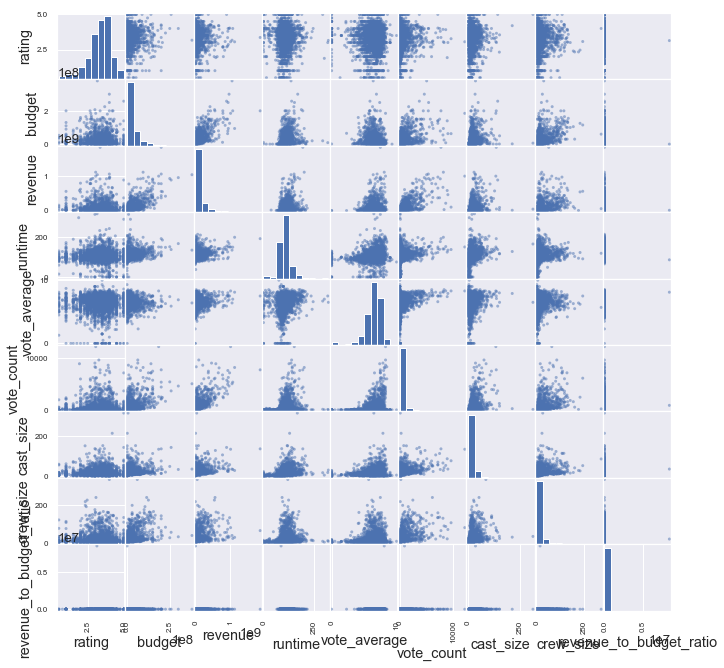

In [429]:
# Examine rating vs numerical features

# movies_rtings_num_features = movies_reduced[["rating","budget", "popularity","revenue","runtime","vote_average","vote_count","cast_size","crew_size","revenue_to_budget_ratio"]].copy()
# movies_rtings_num_features = movies_reduced[["rating","budget"]].copy()
# sns.pairplot(movies_rtings_num_features)

from pandas.plotting import scatter_matrix

attributes = ["rating","budget", "popularity","revenue","runtime","vote_average","vote_count","cast_size","crew_size","revenue_to_budget_ratio"]
scatter_matrix(movies_reduced[attributes], figsize=(11, 11))
plt.show()

* Most of the features are correlated to some extent
* revenue_to_budget_ratio doesn't seem to be correlated with anything - probably can be removed

## Review and Save Enhanced Dataset

In [111]:
# verify the schema and data end results

movies.name = 'movies'
quick_schema_analysis(movies)
quick_data_analysis(movies)

Basic Schema Analysis for dataframe=movies
************************************************
Rows and Columns:
(46628, 32)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 32 columns):
adult                      46628 non-null object
belongs_to_collection      46628 non-null object
budget                     9053 non-null float64
genres                     46628 non-null object
homepage                   8009 non-null object
id                         46628 non-null object
original_language          46617 non-null object
overview                   45633 non-null object
popularity                 46624 non-null object
production_companies       46628 non-null object
production_countries       46628 non-null object
release_date               46540 non-null datetime64[ns]
revenue                    7537 non-null float64
runtime                    46360 non-null float64
spoken_languages           46628 non-null object
status                    

In [112]:
# save movies dataframe to a csv
                    
movies_final_file = os.path.join(PROJECT_LOCAL_DIR, 'movies_final.csv')

print('Saving final model to ' + movies_final_file + '...')

movies.to_csv(movies_final_file,
              encoding='utf-8',
              index=False
              )

print('Model saved.')

Saving final model to /content/movies/movies_final.csv...
Model saved.


# 4.0 Model

## Create the Training and Test Data

In [0]:
target = ['revenue']

y = movies[target].values

X = movies.drop(target, axis=1).values

## Benchmark

## Train

## Test

# 5.0 Analysis

## Plots

## Scoring

# 6.0 Summary

## Observations

## Conclusions